In [489]:
from rfgap import RFGAP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dataset import dataprep
from phate import PHATE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [490]:
# Read in and prepare the data

data_name = 'treeData'
save_figs = True


data   = pd.read_csv('../datasets/' + data_name + '.csv', sep = ',')
x, y   = dataprep(data, scale = None)
n, d   = x.shape
n_classes = len(y.unique())

x_train, x_test, y_train, y_test, inds_train, inds_test = train_test_split(x, y, np.arange(n), test_size=0.1, random_state = 42)

n_test = x_test.shape[0]

In [491]:
# Random forest on all data for PHATE embedding visualization
rfphate = RFGAP(oob_score = True, non_zero_diagonal = True, random_state = 42)
rfphate.fit(x, y)
prox_phate = rfphate.get_proximities()

In [492]:
# Random forest for uncertainty measures; using split datasets
rf = RFGAP(oob_score = True, random_state = 42)
rf.fit(x_train, y_train)
prox = rf.get_proximities()

In [493]:
# Generate OOB and Test trust scores
trust_scores_oob = rf.get_trust_scores()
trust_scores_test = rf.get_test_trust(x_test)

Currently minus not taking oob_correct into account


In [494]:
def reverse_scale_sklearn(x, min_size = 5, max_size = 100):
    scaler = MinMaxScaler(feature_range = (min_size, max_size))

    return max_size - scaler.fit_transform(x) + min_size

In [495]:
# Helper functions for plots
def reverse_scale(x, min_size = 5, max_size = 100, log_scale = False):
    
    if log_scale:
        x = np.log(x + np.finfo(np.float64).eps)
        x_scaled = max_size - (x - x.min())/(x.max() - x.min()) * max_size + min_size
    else:
        x_scaled = max_size - (x - x.min())/(x.max() - x.min()) * max_size + min_size

    return x_scaled

In [496]:
# RF-PHATE embedding for scatterplots
phate_op = PHATE(knn_dist = 'precomputed', verbose = 0)
emb = phate_op.fit_transform(prox_phate)

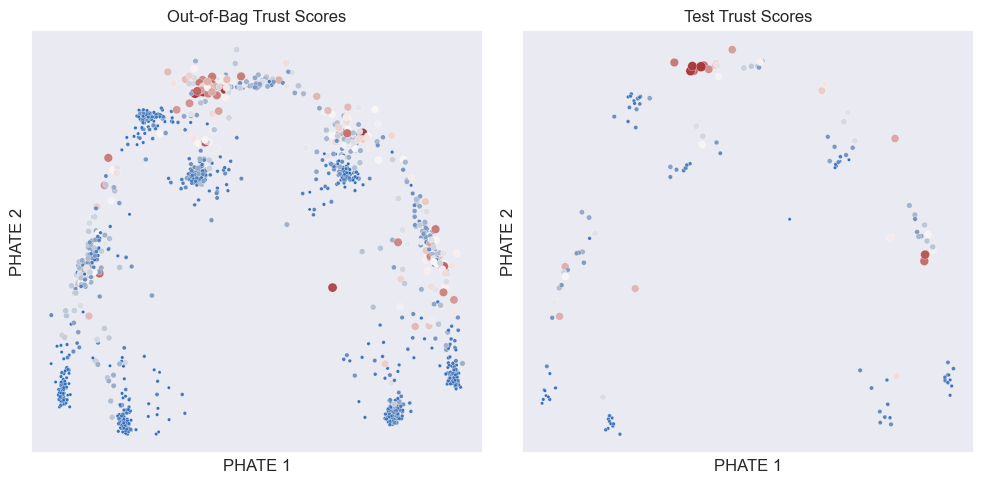

In [497]:
# RF-PHATE train/test plots
sns.set_theme()
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
plt.subplots_adjust(hspace = 0.5, wspace = 0.1)
color_palette = sns.color_palette('vlag', as_cmap = True)


min_size = 5
max_size = 50

hue_norm = (min_size, max_size)

oob_scale = reverse_scale(trust_scores_oob, min_size = min_size, max_size = max_size)
test_scale = reverse_scale(trust_scores_test, min_size = min_size, max_size = max_size)

sns.scatterplot(ax = axes[0], x = emb[inds_train, 0], y = emb[inds_train, 1],
                hue = oob_scale, 
                hue_norm = hue_norm,
                size = oob_scale,
                sizes = (min_size, max_size),
                palette = color_palette)


sns.scatterplot(ax = axes[1], x = emb[inds_test, 0], y = emb[inds_test, 1],
                hue = test_scale, 
                hue_norm = hue_norm,
                size = test_scale,
                sizes = (min_size, max_size),
                palette = color_palette)


axes[0].set_title('Out-of-Bag Trust Scores')
axes[1].set_title('Test Trust Scores')

for ax in axes:
    ax.set_xlabel('PHATE 1')
    ax.set_ylabel('PHATE 2')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend([], [], frameon = False)


plt.tight_layout()

if save_figs:
    plt.savefig('./figures/' + data_name + '_trust_scores_oob_test.pdf')

In [498]:
# Get trust score quantiles for both OOB and Test points
oob_trust_quantiles = rf.trust_quantiles
test_trust_quantiles = rf.trust_quantiles_test

In [499]:
# The number of points dropped based on low trust quantiles
n_oob_dropped = []
n_test_dropped = []

for q in oob_trust_quantiles:
    n_oob_dropped.append(np.sum(trust_scores_oob < q))
n_oob_dropped = np.array(n_oob_dropped)

for q in oob_trust_quantiles:
    n_test_dropped.append(np.sum(trust_scores_test < q))
n_test_dropped = np.array(n_test_dropped)

In [500]:
print(len(n_oob_dropped))
print(len(n_test_dropped))

print(len(oob_trust_quantiles))
print(len(test_trust_quantiles))

100
100
100
100


In [501]:
def nearest_value_index(arr, value):
    return np.argmin(np.abs(arr - value))

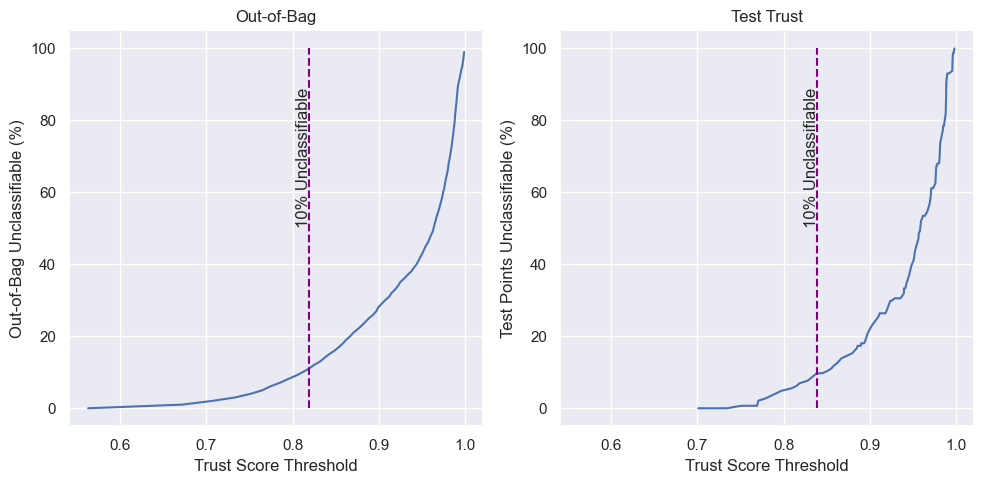

In [502]:
# Plot of test  and oob trust score quantiles
fig, axes = plt.subplots(1, 2, figsize = (10, 5), sharex=True)


sns.lineplot(ax = axes[0], x = oob_trust_quantiles, y = n_oob_dropped / len(y_train) * 100)
sns.lineplot(ax = axes[1], x = test_trust_quantiles, y = n_test_dropped / len(y_test) * 100)

# Vertical Lines
axes[0].vlines(x = oob_trust_quantiles[nearest_value_index(np.round(n_oob_dropped / n, 2), 0.1)], color = 'purple', linestyle = '--',
               ymin = 0, ymax = 100)

axes[0].text(oob_trust_quantiles[nearest_value_index(np.round(n_oob_dropped / n, 2), 0.1)] - 0.015, 50, '10% Unclassifiable', rotation=90, verticalalignment='bottom')

axes[1].vlines(x = test_trust_quantiles[nearest_value_index(np.round(n_test_dropped / n_test, 2), 0.1)], color = 'purple', linestyle = '--',
               ymin = 0, ymax = 100)

axes[1].text(test_trust_quantiles[nearest_value_index(np.round(n_test_dropped / n_test, 2), 0.1)] - 0.015, 50, '10% Unclassifiable', rotation=90, verticalalignment='bottom')

# Horizontal Lines
# Horizontal Lines
# x_value = oob_trust_quantiles[nearest_value_index(np.round(n_oob_dropped / n, 2), 0.1)]
# y_value = np.interp(x_value, oob_trust_quantiles, np.round(n_oob_dropped / n, 2) * 100)
# axes[0].hlines(y = y_value, xmin = np.min(oob_trust_quantiles), xmax = x_value, color = 'green', linestyle = '--')
# axes[0].text(np.min(oob_trust_quantiles), y_value, f'Pct. Unclassifiable: {y_value:.2f}', verticalalignment='bottom')

# x_value = test_trust_quantiles[np.where(np.round(n_test_dropped / n_test, 2) == 0.1)]
# y_value = np.interp(x_value, test_trust_quantiles, np.round(n_test_dropped / n_test, 2) * 100)
# axes[1].hlines(y = y_value, xmin = np.min(test_trust_quantiles), xmax = x_value, color = 'green', linestyle = '--')
# axes[1].text(np.min(test_trust_quantiles), y_value, f'Accuracy: {y_value:.2f}', verticalalignment='bottom')



axes[0].set_title('Out-of-Bag')
axes[0].set_ylabel('Out-of-Bag Unclassifiable (%)')
axes[0].set_xlabel('Trust Score Threshold')

axes[1].set_title('Test Trust')
axes[1].set_ylabel('Test Points Unclassifiable (%)')
axes[1].set_xlabel('Trust Score Threshold')

plt.tight_layout()

if save_figs:
    plt.savefig('./figures/' + data_name + '_pct_dropped.pdf')

In [503]:
# Check accuracy after dropping unclassifiable points
oob_drop_accuracy = []
test_drop_accuracy = []

oob_prop_misclass_dropped = []
test_prop_misclass_dropped = []

for q in oob_trust_quantiles:

    idx_temp = trust_scores_oob >= q
    idx_temp_test = trust_scores_test >= q

    oob_preds = np.argmax(rf.oob_decision_function_, axis = 1)[idx_temp]
    dropped_oob_preds = np.argmax(rf.oob_decision_function_, axis = 1)[~idx_temp]

    oob_drop_accuracy.append(np.mean(y_train[idx_temp] == oob_preds))

    try:
        test_drop_accuracy.append(np.mean(y_test[idx_temp_test] == rf.predict(x_test[idx_temp_test])))

    except:
        test_drop_accuracy.append(1)

    # Add proportion of misclassified points dropped

    oob_prop_misclass_dropped.append(np.mean(y_train[~idx_temp] != dropped_oob_preds))

    try:
        test_prop_misclass_dropped.append(np.mean(y_test[~idx_temp_test] != rf.predict(x_test[~idx_temp_test])))
    except:
        test_prop_misclass_dropped.append(0) # CHECK TO SEE IF THIS MAKES SENSE



oob_drop_accuracy = np.array(oob_drop_accuracy)
test_drop_accuracy = np.array(test_drop_accuracy)

oob_prop_misclass_dropped = np.array(oob_prop_misclass_dropped)
test_prop_misclass_dropped = np.array(test_prop_misclass_dropped)

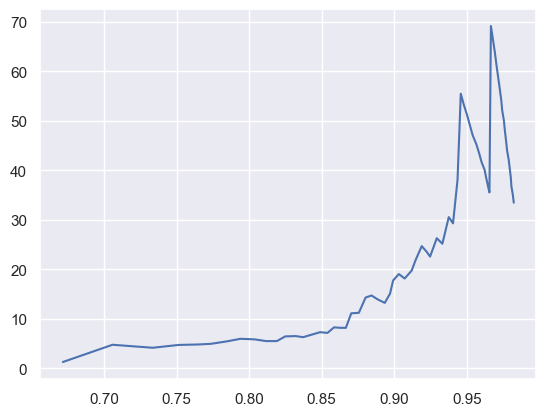

In [504]:
misclass_ratios = oob_prop_misclass_dropped[oob_drop_accuracy < 1] / (1 - oob_drop_accuracy[oob_drop_accuracy < 1])
plt.plot(oob_trust_quantiles[oob_drop_accuracy < 1], misclass_ratios)

C:\Users\rhodes8\AppData\Local\Temp\ipykernel_31380\2230869813.py:1: RuntimeWarning: divide by zero encountered in divide
  misclass_ratios_test = test_prop_misclass_dropped / (1 - test_drop_accuracy)


Text(0, 0.5, 'Ratio: Misclassified Dropped / Not Dropped')

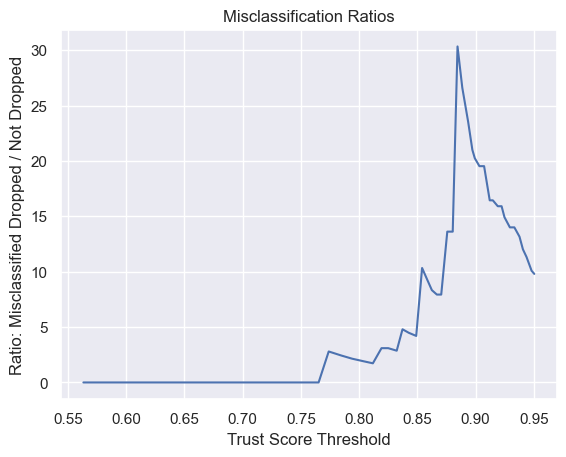

In [505]:
misclass_ratios_test = test_prop_misclass_dropped / (1 - test_drop_accuracy)
plt.plot(oob_trust_quantiles, misclass_ratios_test)
plt.title('Misclassification Ratios')
plt.xlabel('Trust Score Threshold')
plt.ylabel('Ratio: Misclassified Dropped / Not Dropped')

# That is, the higher the trust score, the more likely the model is to misclassify the dropped points

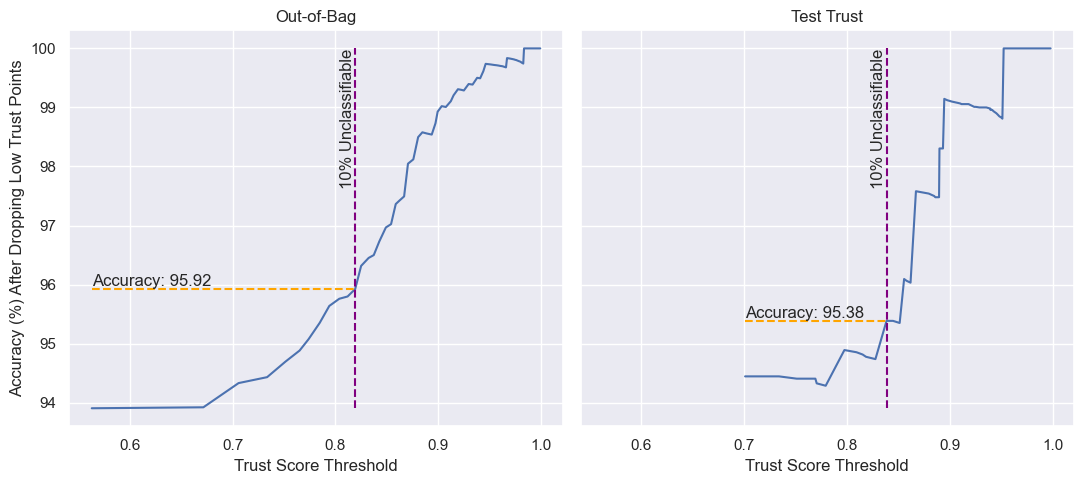

In [506]:
fig, axes = plt.subplots(1, 2, figsize = (11, 5), sharey = True, sharex = True)
plt.subplots_adjust(hspace = 0.5, wspace = 0.1)

sns.lineplot(ax = axes[0], x = oob_trust_quantiles, y = oob_drop_accuracy * 100)
sns.lineplot(ax = axes[1], x = test_trust_quantiles, y = test_drop_accuracy * 100)


axes[0].vlines(x = oob_trust_quantiles[nearest_value_index(np.round(n_oob_dropped / n, 2), 0.1)], color = 'purple', linestyle = '--',
               ymin = np.min(oob_drop_accuracy) * 100, ymax = 100)

axes[1].vlines(x = test_trust_quantiles[nearest_value_index(np.round(n_test_dropped / n_test, 2), 0.1)], color = 'purple', linestyle = '--',
               ymin = np.min(oob_drop_accuracy) * 100, ymax = 100)

axes[0].text(oob_trust_quantiles[nearest_value_index(np.round(n_oob_dropped / n, 2), 0.1)] - 0.015, 100, '10% Unclassifiable', rotation=90, verticalalignment='top')
axes[1].text(test_trust_quantiles[nearest_value_index(np.round(n_test_dropped / n_test, 2), 0.1)] - 0.015, 100, '10% Unclassifiable', rotation=90, verticalalignment='top')

# Horizontal Lines
x_value = oob_trust_quantiles[nearest_value_index(np.round(n_oob_dropped / n, 2), 0.1)]
y_value = np.interp(x_value, oob_trust_quantiles, oob_drop_accuracy * 100)
axes[0].hlines(y = y_value, xmin = np.min(oob_trust_quantiles), xmax = x_value, color = 'orange', linestyle = '--')
axes[0].text(np.min(oob_trust_quantiles), y_value, f'Accuracy: {y_value:.2f}', verticalalignment='bottom')

x_value = test_trust_quantiles[nearest_value_index(np.round(n_test_dropped / n_test, 2), 0.1)]
y_value = np.interp(x_value, test_trust_quantiles, test_drop_accuracy * 100)
axes[1].hlines(y = y_value, xmin = np.min(test_trust_quantiles), xmax = x_value, color = 'orange', linestyle = '--')
axes[1].text(np.min(test_trust_quantiles), y_value, f'Accuracy: {y_value:.2f}', verticalalignment='bottom')

axes[0].set_title('Out-of-Bag')
axes[0].set_ylabel('Accuracy (%) After Dropping Low Trust Points')
axes[0].set_xlabel('Trust Score Threshold')

axes[1].set_title('Test Trust')
axes[1].set_xlabel('Trust Score Threshold')

plt.tight_layout()

if save_figs:
    plt.savefig('./figures/' + data_name + '_accuracy_after_dropped.pdf')

In [507]:
rffull = RFGAP(oob_score = True, random_state = 42)
rffull.fit(x, y)
full_trust_scores = rffull.get_trust_scores()

Currently minus not taking oob_correct into account


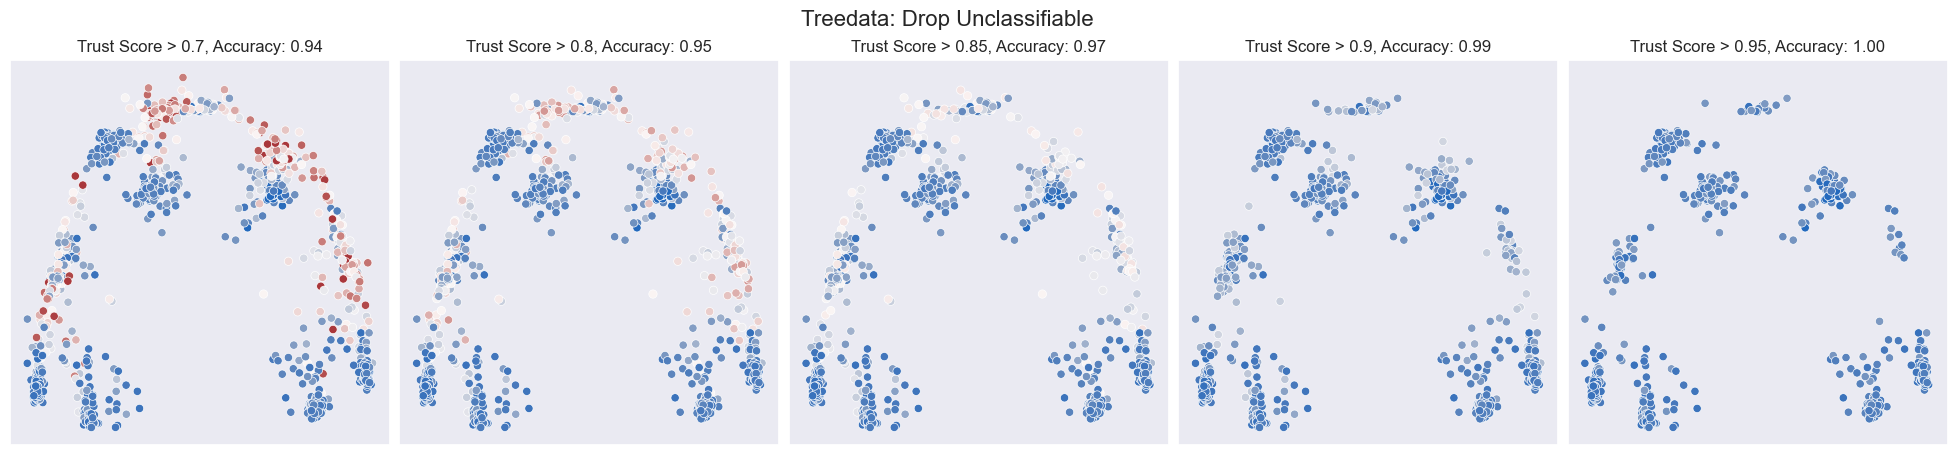

In [508]:
qs = [0.7, 0.8, 0.85, 0.9, 0.95]

fig, axes = plt.subplots(1, 5, figsize = (25, 5), sharex = True, sharey = True)
plt.subplots_adjust(hspace = 0.5, wspace = 0.025)
color_palette = sns.color_palette('vlag', as_cmap = True)

# Define size and colormap outside the loop
size = reverse_scale(full_trust_scores)
colormap = reverse_scale(full_trust_scores)
hue_norm = (int(np.min(colormap)), int(np.quantile(colormap, 0.97)))

for i, ax in enumerate(axes.ravel()):

    q = qs[i]
    idx_temp = full_trust_scores > q
    oob_preds = np.argmax(rffull.oob_decision_function_, axis = 1)[idx_temp]

    sns.scatterplot(ax = ax, x = emb[idx_temp, 0], y = emb[idx_temp, 1],
                    hue = colormap[idx_temp],
                    hue_norm = hue_norm,
                    sizes = size[idx_temp],
                    palette = color_palette,
                    legend = False)  # Disable legend for each subplot
    
    ax.set_title(f'Trust Score > {q}, Accuracy: {np.mean(y[idx_temp] == oob_preds):.2f}')
    ax.set_xticks([])
    ax.set_yticks([])   

fig.suptitle(str.title(data_name) + ': Drop Unclassifiable', fontsize=16)

if save_figs:
    plt.savefig('./figures/' + data_name + '_trust_scores_sequence.png')

In [509]:
phate_op = PHATE(t = 150, gamma = 0, verbose = 0)
phate_emb = phate_op.fit_transform(x)

Text(0.5, 0.98, 'Treedata: Drop Unclassifiable')

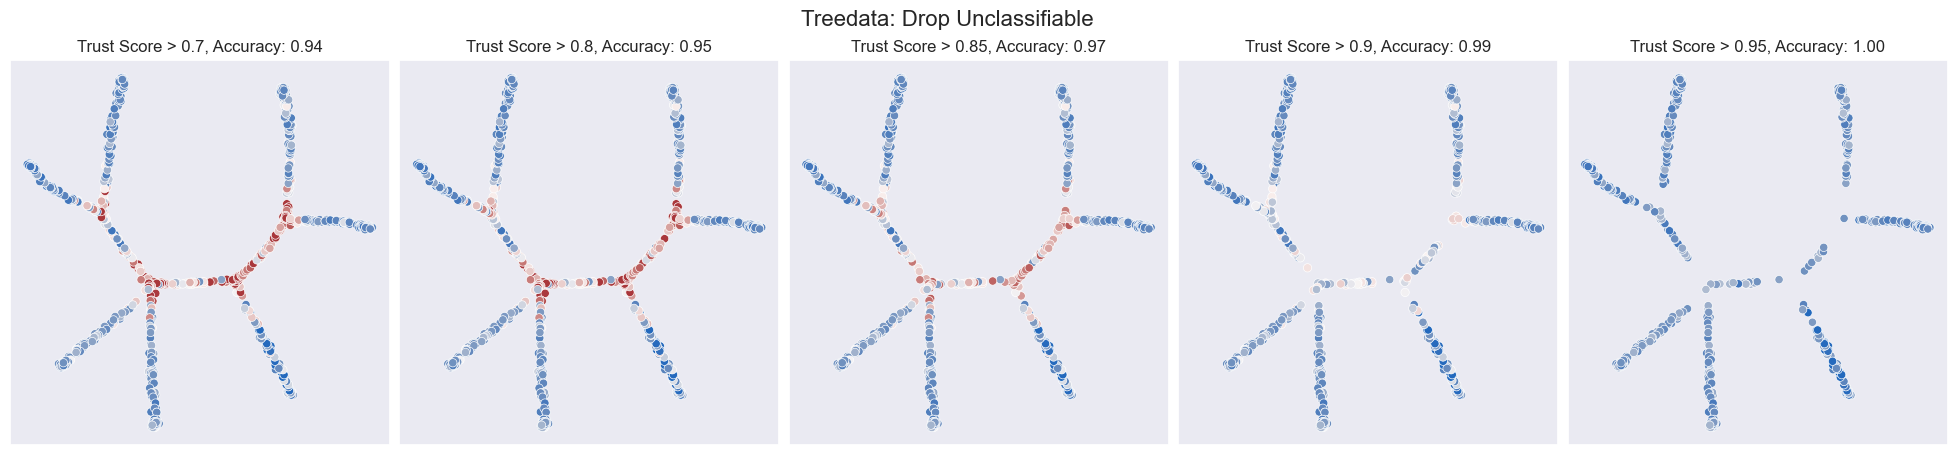

In [510]:
qs = [0.7, 0.8, 0.85, 0.9, 0.95]

fig, axes = plt.subplots(1, 5, figsize = (25, 5), sharex = True, sharey = True)
plt.subplots_adjust(hspace = 0.5, wspace = 0.025)
color_palette = sns.color_palette('vlag', as_cmap = True)

# Define size and colormap outside the loop
size = reverse_scale(full_trust_scores)
colormap = reverse_scale(full_trust_scores)
hue_norm = (int(np.min(colormap)), int(np.quantile(colormap, 0.85)))

for i, ax in enumerate(axes.ravel()):

    q = qs[i]
    idx_temp = full_trust_scores > q
    oob_preds = np.argmax(rffull.oob_decision_function_, axis = 1)[idx_temp]

    sns.scatterplot(ax = ax, x = phate_emb[idx_temp, 0], y = phate_emb[idx_temp, 1],
                    hue = colormap[idx_temp],
                    hue_norm = hue_norm,
                    sizes = size[idx_temp],
                    palette = color_palette,
                    legend = False)  # Disable legend for each subplot
    
    ax.set_title(f'Trust Score > {q}, Accuracy: {np.mean(y[idx_temp] == oob_preds):.2f}')
    ax.set_xticks([])
    ax.set_yticks([])   

fig.suptitle(str.title(data_name) + ': Drop Unclassifiable', fontsize=16)

In [511]:
thresholds_table = np.linspace(0.05, 0.95, int(0.95 / 0.05))
print(thresholds_table)

[0.05       0.10294118 0.15588235 0.20882353 0.26176471 0.31470588
 0.36764706 0.42058824 0.47352941 0.52647059 0.57941176 0.63235294
 0.68529412 0.73823529 0.79117647 0.84411765 0.89705882 0.95      ]


In [512]:
int(0.95 / 0.05)

18

In [513]:

# Table of results
thresholds_table = np.round(np.linspace(0.05, .95, 19), 2)
# oob_trust_quantiles_table = np.quantile(trust_scores_oob, quantiles_table)
dataset_name_table = np.repeat(data_name, len(thresholds_table))
oob_drop_accuracy_table = oob_drop_accuracy[[int(quantile * 100) for quantile in thresholds_table]]
n_oob_dropped_table = n_oob_dropped[[int(quantile * 100) for quantile in thresholds_table]]
oob_accuracy_table = np.repeat(rf.oob_score_, len(thresholds_table))
accuracy_diff_table = oob_drop_accuracy_table - oob_accuracy_table
accuracy_drop_ratio = (accuracy_diff_table) / (n_oob_dropped_table / n)

# Headers

headers = ['Dataset', 'Trust Threshold', 'Baseline Accuracy', 
           'Classifiable Accuracy','Accuracy Diff', 'Pct. Dropped',
           'Accuracy Drop Ratio']

table = pd.DataFrame(np.vstack([dataset_name_table, thresholds_table, 
                                oob_accuracy_table, oob_drop_accuracy_table,
                                  accuracy_diff_table, n_oob_dropped_table / n,
                                    accuracy_drop_ratio]).T, columns = headers)


if save_figs:
    table.to_csv('./trust_tables/' + data_name + '_trust_table.csv', index = False)

In [514]:
table # Wrong: Not quantiles, but thresholds!

,Dataset,Trust Threshold,Baseline Accuracy,Post Drop Accuracy,Accuracy Diff,Pct. Dropped Points,Accuracy Drop Ratio
0,treeData,0.05,0.9390432098765432,0.9488220958570268,0.009778885980483598,0.04513888888888889,0.21663993556763664
1,treeData,0.1,0.9390432098765432,0.9579759862778731,0.018932776401329843,0.09027777777777778,0.20971690783011518
2,treeData,0.15,0.9390432098765432,0.9673024523160763,0.02825924243953304,0.13541666666666666,0.2086836364765517
3,treeData,0.2,0.9390432098765432,0.9749276759884281,0.035884466111884894,0.1798611111111111,0.19951208957959168
4,treeData,0.25,0.9390432098765432,0.98559670781893,0.046553497942386834,0.225,0.20690443529949704
5,treeData,0.3,0.9390432098765432,0.9900771775082691,0.05103396763172585,0.2701388888888889,0.188917515140579
6,treeData,0.35,0.9390432098765432,0.9928741092636579,0.05383089938711472,0.31527777777777777,0.17074117867278676
7,treeData,0.4,0.9390432098765432,0.9961439588688946,0.0571007489923514,0.3597222222222222,0.1587356728744904
8,treeData,0.45,0.9390432098765432,0.9971949509116409,0.05815174103509768,0.4048611111111111,0.1436338028997267
9,treeData,0.5,0.9390432098765432,0.9969135802469136,0.05787037037037035,0.45,0.12860082304526743


Text(0, 0.5, '(Accuracy Increase / Pct. Dropped Points)')

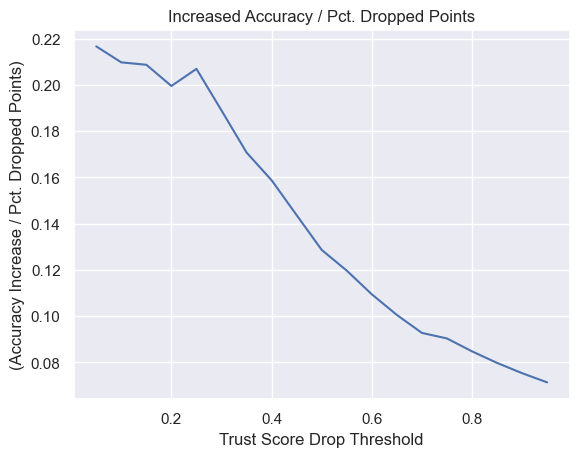

In [515]:
fig = sns.lineplot(x = thresholds_table, y = accuracy_drop_ratio)

fig.set_title('Increased Accuracy / Pct. Dropped Points')
fig.set_xlabel('Trust Score Drop Threshold')
fig.set_ylabel('(Accuracy Increase / Pct. Dropped Points)')
